In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_palette('colorblind'); sns.set_color_codes()
from theano import tensor as tt

#### Code 13.1

In [2]:
a = 3.5  # average morning wait time
b = -1  # average difference afternoon wait time
sigma_a = 1  # std dev in intercepts
sigma_b = 0.5  # std dev in slopes
rho = -0.7  # correlation between intercepts and slopes

#### Code 13.2

In [3]:
Mu = [a, b]  

#### Code 13.3

In [4]:
cov_ab = sigma_a * sigma_b * rho
Sigma = np.array([[sigma_a**2, cov_ab], [cov_ab, sigma_b**2]])
Sigma

array([[ 1.  , -0.35],
       [-0.35,  0.25]])

#### Code 13.4

The code 13.4 and the related comment in the book is particular to R and not relevant for Python.

#### Code 13.5

In [5]:
sigmas = [sigma_a, sigma_b]
Rho = np.matrix([[1, rho], [rho, 1]])

Sigma = np.diag(sigmas) * Rho * np.diag(sigmas)
Sigma

matrix([[ 1.  , -0.35],
        [-0.35,  0.25]])

#### Code 13.6 and 13.7

In [6]:
N_cafes = 20
np.random.seed(42)
vary_effects = np.random.multivariate_normal(mean=Mu, cov=Sigma, size=N_cafes)

Instead of having individual arrays `a_cafe` and `b_cafe`, I'll place all these values in a DataFrame for easy manipulation.

In [7]:
df = pd.DataFrame(vary_effects, columns = ['a_cafe', 'b_cafe'])
df.head()

,a_cafe,b_cafe
0,2.990071,-0.848751
1,3.044156,-0.272349
2,3.703643,-1.164509
3,2.026929,-0.143253
4,4.032522,-1.014692


#### Code 13.9

Instead of using confidence region ellipses (Seaborn doesn't have this functionality)
we'll be using KDEs. To make the kde smoother we will use a sample size larger than the one `vary_effects`

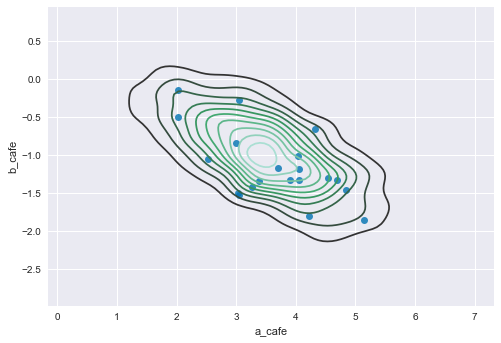

In [8]:
np.random.seed(42)
vary_effects_larger = np.random.multivariate_normal(mean=Mu, cov=Sigma, size=1000)
sns.kdeplot(vary_effects_larger)  # KDE plot (substitute for confidence ellipses)
sns.regplot(df.a_cafe, df.b_cafe, fit_reg=False);  # scatter plot with no regression line

#### Code 13.10 (Simulate the observations)

In [9]:
N_visits = 10
afternoon = np.tile([0,1], int(N_visits * N_cafes/2))  # wrap with int() to suppress warnings
cafe_id = np.tile(np.arange(1, N_cafes+1), N_visits)  # 1-20

# Replicate df (which contains a_cafe and b_cafe) N_visits times to get full
# design matrix
d = pd.concat([df]*N_visits)\
    .reset_index(drop=True)
d['cafe_id'] = cafe_id
d['afternoon'] = afternoon
d['mu'] = d['a_cafe'] + d['b_cafe'] * d['afternoon']
sigma = 0.5  # std dev within cafes
wait = np.random.normal(d['mu'], np.repeat(sigma, len(d)))
d['wait'] = wait

#### Code 13.12-13.13

Partially adapted from:
- http://twiecki.github.io/blog/2014/03/17/bayesian-glms-3/
- https://pymc-devs.github.io/pymc3/notebooks/LKJ.html

In [10]:
cafe_idx = d['cafe_id'].values - 1  # index for cafe_id. Python is 0-indexed
# Model specification on pg 393, but pymc3 requires us to go from bottom to top
with pm.Model() as hierarchical_model:
    
    sigma_a = pm.HalfCauchy('sigma_a', beta=1)  # prior stddev among intercepts
    sigma_b = pm.HalfCauchy('sigma_b', beta=1)  # prior stddev among intercepts
    # We need to create a matrix with sigma on diagonal, 0 everywhere else.
    # tt.nlinalg.diag is equivalent to np.diag() used above
    sigma_diag = pm.Deterministic('sigma_diag', tt.nlinalg.diag([sigma_a, sigma_b]))
    
    sigma = pm.HalfCauchy('sigma', beta=1)      # prior stddev within cafes

    rho = pm.LKJCorr('rho', n=2, p=2)  # prior for correlation matrix. n is shape parameter, p is dimension
    # There is a slight complication in how PyMC3 handles LKJCorr values.
    # It only returns the upper triangular elements. But we need a full matrix, in Theano's
    # tensor format.
    # See https://pymc-devs.github.io/pymc3/notebooks/LKJ.html
    # The next line creates the correlation matrix Rho (1 on diagonals). 
    # Index by np.zeros just sets all values in matrix to rho, then tt.fill_diagonal fills diagonals with 1
    Rho = pm.Deterministic('Rho', tt.fill_diagonal(rho[np.zeros((2, 2), dtype=np.int64)], 1.))
    # finally, the covariance matrix
    cov = pm.Deterministic('cov', tt.nlinalg.matrix_dot(sigma_diag, Rho, sigma_diag))
    
    a = pm.Normal('a', mu=0, sd=10)  # prior for average intercept
    b = pm.Normal('b', mu=0, sd=10)  # prior for average slope
    
    ab_cafe = pm.MvNormal('ab_cafe', mu=tt.stack([a,b]), cov=cov, shape=(N_cafes, 2)) # Population of varying effects
    # Shape needs to be (N_cafes, 2) because we're getting back both a and b for each cafe
    
    mu = ab_cafe[:, 0][cafe_idx] + ab_cafe[:, 1][cafe_idx] * d['afternoon'].values  # linear model
    wait = pm.Normal('wait', mu=mu, sd=sigma, observed=d['wait'])  # likelihood

In [11]:
# Run inference. 
# For this problem, metropolis is sufficient and fastest. (this code takes about 1 minute)
# Find MAP to get faster convergence
# Using more iterations than the book because Metropolis takes a while to converge
# (book uses Hamiltonian Monte Carlo)
# Using ADVI inference also sometimes leads to singular matrix errors... (not sure why)
num_samples = 50000
burnin = int(num_samples/2)
with hierarchical_model:
    step = pm.Metropolis()
    map_estimate = pm.find_MAP()
    trace = pm.sample(num_samples, step, start=map_estimate, random_seed=42)

100%|██████████| 50000/50000 [01:57<00:00, 426.68it/s]  | 1/50000 [00:00<3:04:18,  4.52it/s]

         Current function value: 157.303272
         Iterations: 61
         Function evaluations: 174
         Gradient evaluations: 154


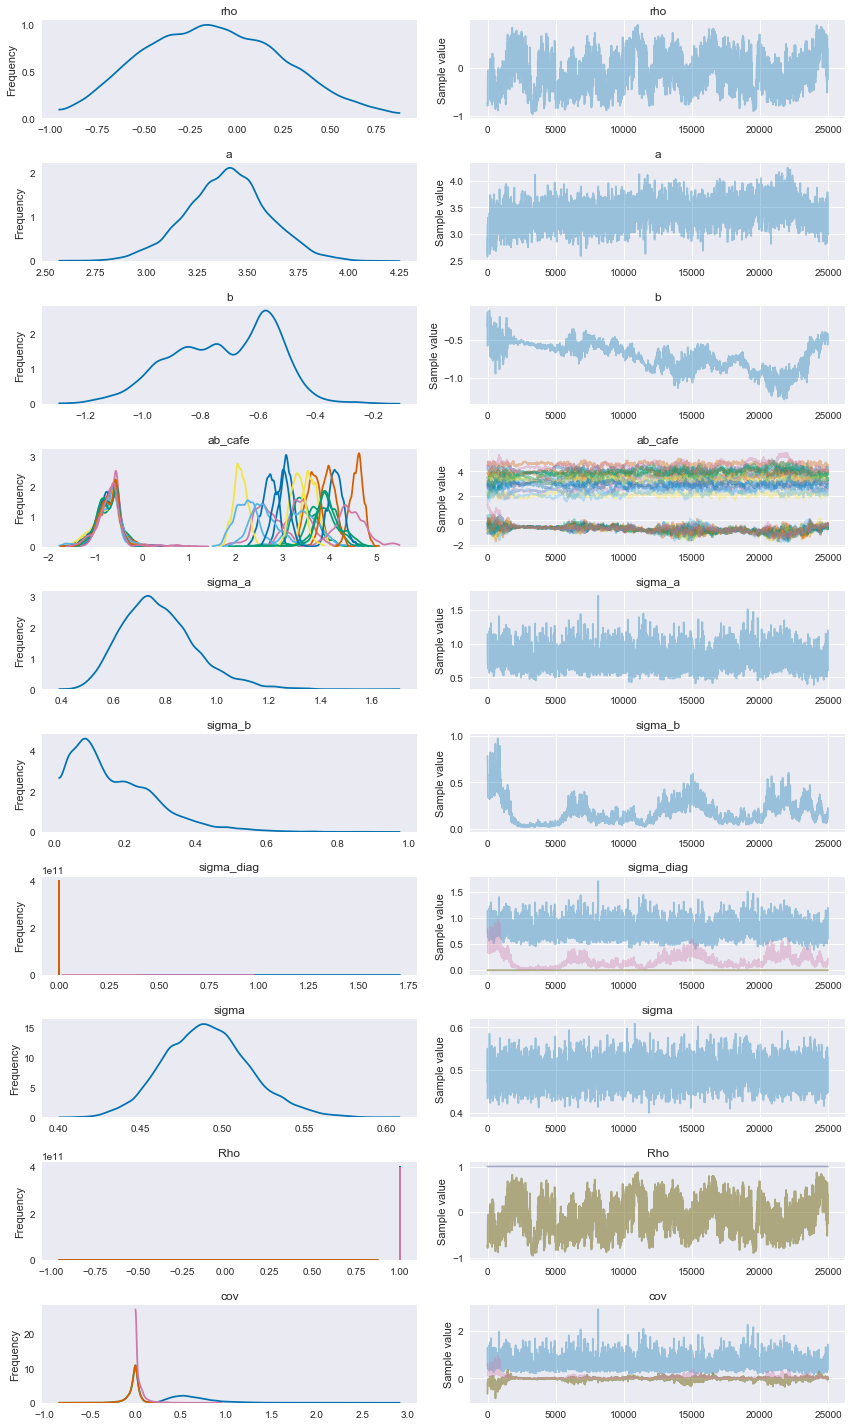

In [12]:
pm.traceplot(trace[burnin:]);

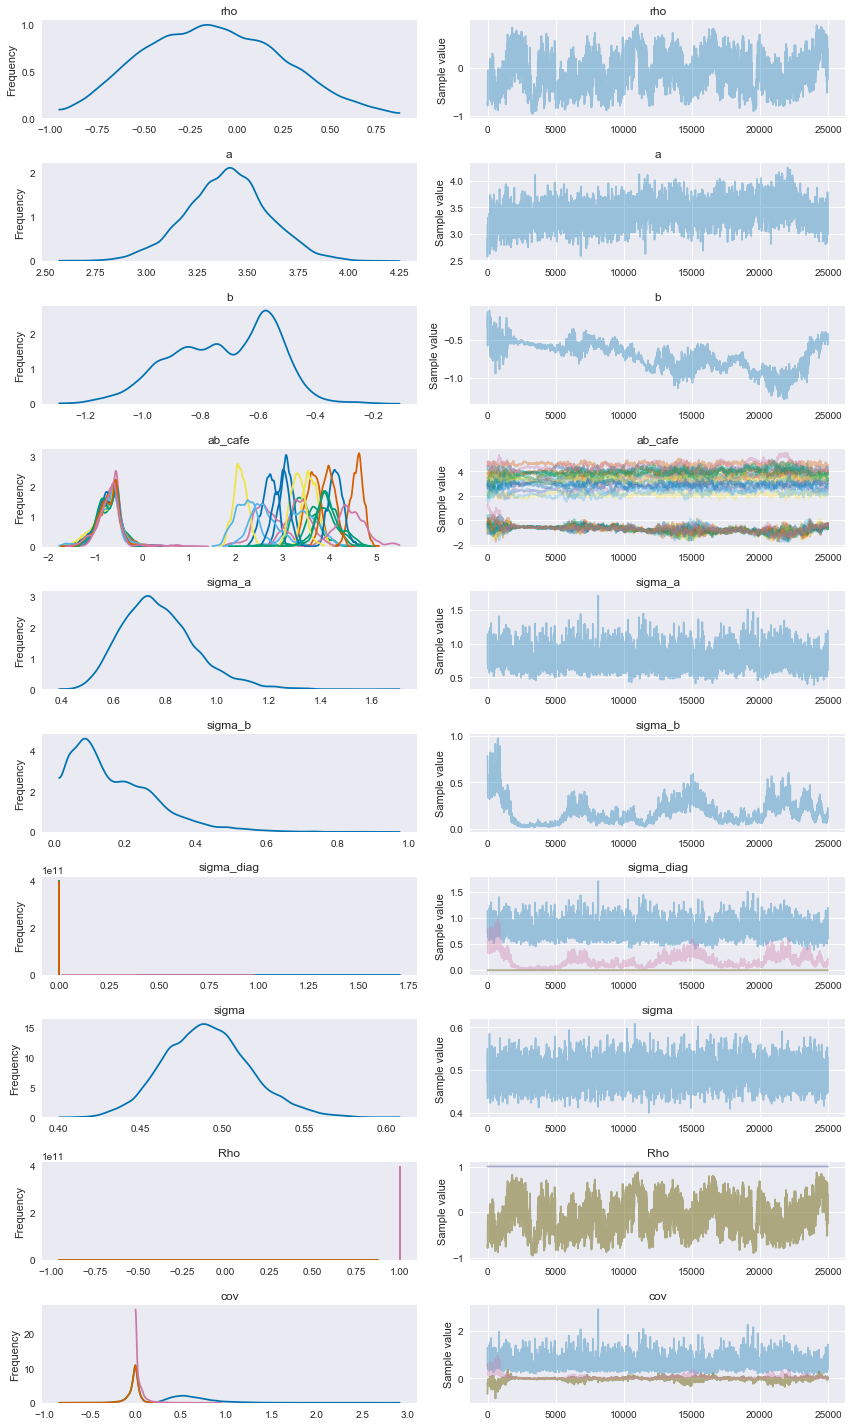

In [13]:
pm.traceplot(trace[burnin:]);

Looks good! The model seems to be able to recover the initial values `a`, `b`, `rho` and `sigma`s.

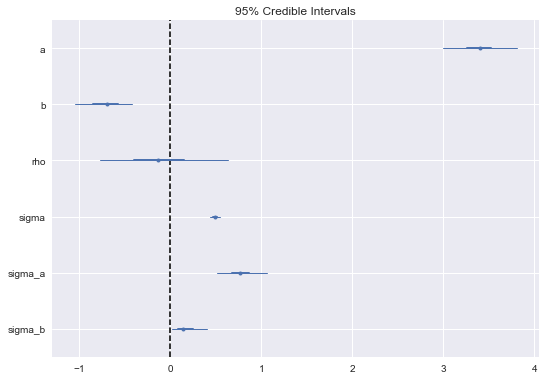

In [14]:
pm.forestplot(trace[burnin:], varnames=['a', 'b', 'rho', 'sigma', 'sigma_a', 'sigma_b']);

In [15]:
trace_df = pm.trace_to_dataframe(trace[burnin:])
trace_df.head()

,sigma_b,Rho__0_0,Rho__0_1,Rho__1_0,Rho__1_1,a,sigma_a,sigma_diag__0_0,sigma_diag__0_1,sigma_diag__1_0,...,ab_cafe__17_1,ab_cafe__18_0,ab_cafe__18_1,ab_cafe__19_0,ab_cafe__19_1,rho__0,cov__0_0,cov__0_1,cov__1_0,cov__1_1
0,0.785820,1.0,-0.72685,-0.72685,1.0,2.910878,1.133547,1.133547,0.0,0.0,...,-0.079502,2.871067,-0.226355,2.071344,1.274214,-0.72685,1.284928,-0.647451,-0.647451,0.617513
1,0.785820,1.0,-0.72685,-0.72685,1.0,2.569754,1.133547,1.133547,0.0,0.0,...,-0.120471,2.927026,-0.223679,2.043308,1.215350,-0.72685,1.284928,-0.647451,-0.647451,0.617513
2,0.726042,1.0,-0.72685,-0.72685,1.0,2.609072,1.133547,1.133547,0.0,0.0,...,-0.120471,2.927026,-0.223679,2.043308,1.215350,-0.72685,1.284928,-0.598200,-0.598200,0.527137
3,0.726042,1.0,-0.72685,-0.72685,1.0,2.609072,0.950402,0.950402,0.0,0.0,...,-0.120471,2.927026,-0.223679,2.043308,1.215350,-0.72685,0.903264,-0.501550,-0.501550,0.527137
4,0.726042,1.0,-0.72685,-0.72685,1.0,2.609072,0.950402,0.950402,0.0,0.0,...,-0.120471,2.927026,-0.223679,2.043308,1.215350,-0.72685,0.903264,-0.501550,-0.501550,0.527137


In [16]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))

This notebook was createad on a computer x86_64 running debian stretch/sid and using:
Python 3.5.2
IPython 5.1.0
PyMC3 3.0
NumPy 1.11.3
SciPy 0.18.1
Matplotlib 2.0.0
Seaborn 0.7.1

